# CHECK THE TODOS
## Confronto modelli KNN su dataset Empty, Crowded e Hybrid
### 1. Import delle librerie e caricamento dei dati

In [52]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# Importing dataset
file_path_bin = "../../data/processed/wifi_fingerprinting_dataset_binarized.csv"
file_path_norm = "../../data/processed/wifi_fingerprinting_dataset_normalized.csv"
file_path_0 = "../../data/raw//wifi_fingerprinting_dataset.csv"
file_path_200 = "../../data/raw/wifi_fingerprinting_dataset_cut_200_ap27.csv"
file_path_400 = "../../data/processed/wifi_fingerprinting_dataset_cut_400_ap22.csv"


df = pd.read_csv(file_path_400, sep=',')

# TODO OK????
# Filling NaN values with -100 RSSI: the worst possible signal
# With dataset_binarized and dataset_normalized all RSSI are already filled
# and no values will be added
df.fillna(-100, inplace=True)

# Creating different dataframes based on room situation: empty, crowded and hybrid (a mix of the two)
# For each dataframe "Situazione" column is dropped
df_empty = df[df["Situazione"] == "Empty"].drop(columns=["Situazione"])
df_crowded = df[df["Situazione"] == "Crowded"].drop(columns=["Situazione"])
df_hybrid = df.drop(columns=["Situazione"])

### 2. Creazione dei modelli

In [54]:
def split_data(df):
    X = df.drop(columns=["Aula"])
    y = df["Aula"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

X_train_empty, X_test_empty, y_train_empty, y_test_empty = split_data(df_empty)
X_train_crowded, X_test_crowded, y_train_crowded, y_test_crowded = split_data(df_crowded)
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = split_data(df_hybrid)

# Display the number of samples in each split for all datasets
def print_split_info(name, X_train, X_test):
    print(f"\n{name} dataset:")
    print(f"  Train set:      {X_train.shape[0]} samples")
    print(f"  Test set:       {X_test.shape[0]} samples")

print_split_info("Empty", X_train_empty, X_test_empty)
print_split_info("Crowded", X_train_crowded, X_test_crowded)
print_split_info("Hybrid", X_train_hybrid, X_test_hybrid)


Empty dataset:
  Train set:      242 samples
  Test set:       242 samples

Crowded dataset:
  Train set:      249 samples
  Test set:       250 samples

Hybrid dataset:
  Train set:      491 samples
  Test set:       492 samples


### 3. Addestramento dei modelli

In [55]:
# Grid Search with Cross-Validation
def find_best_knn(X_train, y_train):
    param_grid = {
        'n_neighbors': range(1, 21),            #TODO: HOW  MUCH RANGE MAX?
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'p': [1, 2]        #TODO NECESSARY?
    }

    knn = KNeighborsClassifier()

    # StratifiedKFold: splits data into k folds, but ensures each fold has the same distribution of class labels

    #TODO ACCURACY BEST SCORING METHOD?
    grid_search = GridSearchCV(knn, param_grid, cv=StratifiedKFold(n_splits=4), scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train) ## TODO really necessary?

    return grid_search.best_params_, grid_search.best_score_

best_params_empty, acc_empty = find_best_knn(X_train_empty, y_train_empty)
best_params_crowded, acc_crowded = find_best_knn(X_train_crowded, y_train_crowded)
best_params_hybrid, acc_hybrid = find_best_knn(X_train_hybrid, y_train_hybrid)

print(f"Empty -> Best params: {best_params_empty}, Best accuracy: {acc_empty:.4f}")
print(f"Crowded -> Best params: {best_params_crowded}, Best accuracy: {acc_crowded:.4f}")
print(f"Hybrid -> Best params: {best_params_hybrid}, Best accuracy: {acc_hybrid:.4f}")

Empty -> Best params: {'metric': 'euclidean', 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}, Best accuracy: 0.9959
Crowded -> Best params: {'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}, Best accuracy: 1.0000
Hybrid -> Best params: {'metric': 'euclidean', 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}, Best accuracy: 1.0000


### 5. Risultati

In [56]:
# Function to evaluate the model on the test set and display summary metrics
def evaluate_on_test_summary(X_train, y_train, X_test, y_test, best_params, label):
    # Use the best parameters found during grid search
    model = KNeighborsClassifier(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    type_dict = {
        "Model": label,
        "Metric": best_params['metric'],
        "Neighbors": best_params['n_neighbors'],
        "p": best_params['p'],
        "Weights": best_params['weights']
    }

    metric_dict = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

    return type_dict, metric_dict


# Evaluate on the test set with the best parameters for each dataset
results = []
results.append(evaluate_on_test_summary(X_train_empty, y_train_empty, X_test_empty, y_test_empty, best_params_empty, "Empty"))
results.append(evaluate_on_test_summary(X_train_crowded, y_train_crowded, X_test_crowded, y_test_crowded, best_params_crowded, "Crowded"))
results.append(evaluate_on_test_summary(X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, best_params_hybrid, "Hybrid"))


type_data = []
metric_data = []

for result in results:
    type_dict, metric_dict = result
    type_data.append(type_dict)
    metric_data.append(metric_dict)

# Create DataFrames from type and metric dictionaries
type_df = pd.DataFrame(type_data)
metric_df = pd.DataFrame(metric_data)

# Print the results
print("\nSummary of test set results (Model Parameters):")
print(type_df.round(3))

print("\nSummary of test set results (Metrics):")
print(metric_df.round(3))



Summary of test set results (Model Parameters):
     Model     Metric  Neighbors  p  Weights
0    Empty  euclidean          2  1  uniform
1  Crowded  euclidean          5  1  uniform
2   Hybrid  euclidean          2  1  uniform

Summary of test set results (Metrics):
   Accuracy  Precision  Recall  F1-score
0     0.992      0.992   0.992     0.992
1     1.000      1.000   1.000     1.000
2     0.998      0.998   0.998     0.998



Confusion matrices:


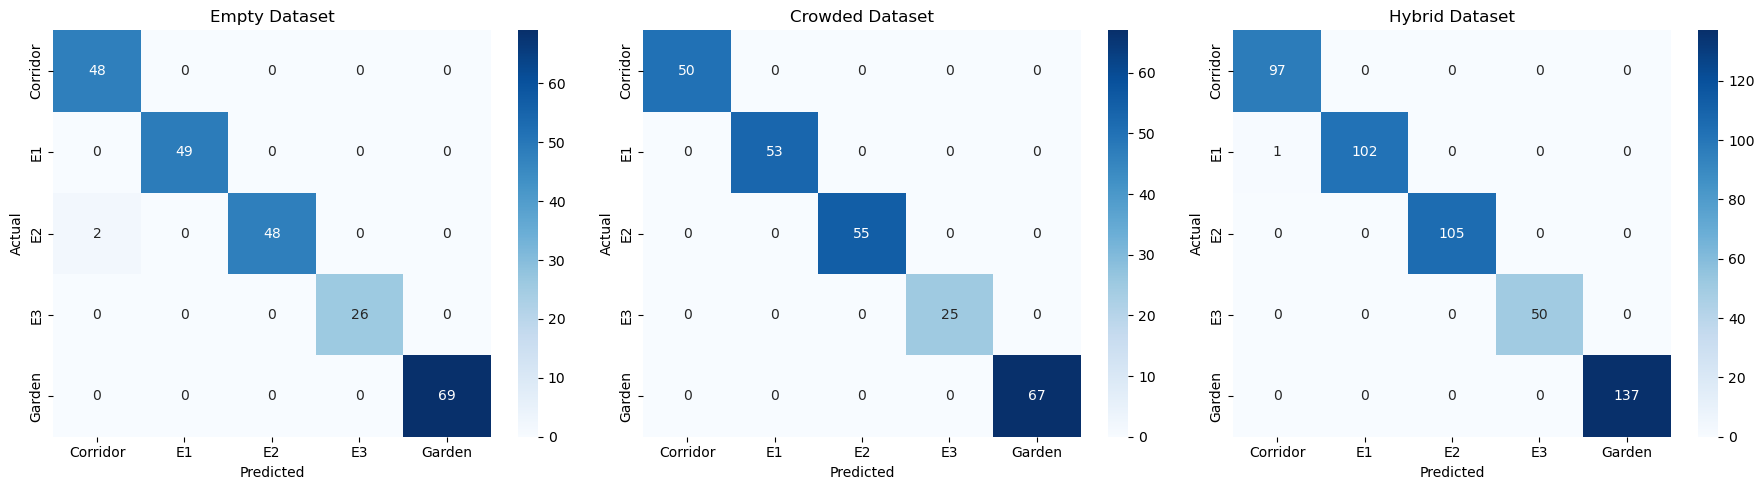

In [57]:
# Plot confusion matrices for the best models
def plot_conf_matrices():
    datasets = [
        ("Empty", X_train_empty, y_train_empty, X_test_empty, y_test_empty, best_params_empty),
        ("Crowded", X_train_crowded, y_train_crowded, X_test_crowded, y_test_crowded, best_params_crowded),
        ("Hybrid", X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, best_params_hybrid),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create a row of 3 subplots
    for ax, (label, X_train, y_train, X_test, y_test, best_params) in zip(axes, datasets):
        # Train the model with the best hyperparameters
        model = KNeighborsClassifier(**best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Generate the confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), ax=ax)
        ax.set_title(f"{label} Dataset")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

# Display the confusion matrices
print("\nConfusion matrices:")
plot_conf_matrices()